# Predicting next word

The main idea here is to build a minimal model able to predict the next word based on typing words.

As result, it's expected:

  - create a step by step guideline for basic NLP research;
  - comparing different models;
  - getting the best model;
  - define a function to test the model interactively.

### 1) Importing essential libraries

In [1]:
from urllib.request import urlopen

from nltk.tokenize import word_tokenize

import numpy as np

import tensorflow as tf

import nltk

import re

import pickle

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### 2) Importing the data from [Gutenberg](https://www.gutenberg.org) project

Here will be used data from 5 books.

All texts will be used in the direct form from the site.

In [3]:
data1 = urlopen('https://www.gutenberg.org/cache/epub/66235/pg66235.txt')
text1 = (data1.read()).decode('utf-8')

data2 = urlopen('https://www.gutenberg.org/cache/epub/66234/pg66234.txt')
text2 = (data2.read()).decode('utf-8')

data3 = urlopen('https://www.gutenberg.org/cache/epub/66232/pg66232.txt')
text3 = (data3.read()).decode('utf-8')

data4 = urlopen('https://www.gutenberg.org/cache/epub/66231/pg66231.txt')
text4 = (data4.read()).decode('utf-8')

data5 = urlopen('https://www.gutenberg.org/cache/epub/66230/pg66230.txt')
text5 = (data5.read()).decode('utf-8')

text = text1 + text2 + text3 + text4 + text5

del text1, text2, text3, text4, text5 # delete to prevent storage unnecessary
len(text)

606792

### 3) Basic preprocessing

- Cleaning texts
- Creating tokens
- Text to numeric sequences

In [4]:
%cd drive/MyDrive/Colab\ Notebooks/NLP

/content/drive/MyDrive/Colab Notebooks/NLP


In [5]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/NLP'

In [6]:
cleaned = re.sub(r'\W+', ' ', text).lower()
tokens = word_tokenize(cleaned)

train_len = 3+1
text_sequences = []
for i in range(train_len,len(tokens)):
    seq = tokens[i-train_len:i]
    text_sequences.append(seq)

sequences = {}
count = 1
for i in range(len(tokens)):
    if tokens[i] not in sequences:
        sequences[tokens[i]] = count
        count += 1
      
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(text_sequences)
# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

sequences = tokenizer.texts_to_sequences(text_sequences) 
 
vocabulary_size = len(tokenizer.word_counts)+1

n_sequences = np.empty([len(sequences),train_len], dtype='int32')
for i in range(len(sequences)):
    n_sequences[i] = sequences[i]

In [7]:
# Examples of sequences:

for n in range(2):
    k = np.random.choice(range(len(n_sequences)))
    for i in sequences[k]:
        print(tokens[i])
    print('\n')

to
the
wait
ebook


any
the
you
gutenberg




### 4) Dividing data

- training and target datasets

In [8]:
train = n_sequences[:, :-1]
target = n_sequences[:, -1]
target = tf.keras.utils.to_categorical(target, num_classes = vocabulary_size)
seq_len = train.shape[1]
print(train.shape)
print(target[0])

(105834, 3)
[0. 0. 0. ... 0. 0. 0.]


### 5) Creating a model

- model1: minimal model

In [9]:
model0 = tf.keras.models.Sequential()
model0.add(tf.keras.layers.Embedding(vocabulary_size, 10, input_length=3))
model0.add(tf.keras.layers.LSTM(1000, return_sequences=True))
model0.add(tf.keras.layers.LSTM(1000))
model0.add(tf.keras.layers.Dense(1000, activation="relu"))
model0.add(tf.keras.layers.Dense(vocabulary_size, activation='softmax'))

print(model0.summary())

model0.compile(loss='categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 3, 10)             95200     
_________________________________________________________________
lstm (LSTM)                  (None, 3, 1000)           4044000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dense_1 (Dense)              (None, 9520)              9529520   
Total params: 22,673,720
Trainable params: 22,673,720
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
# Essential callbacks to follow the training model

es = tf.keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 1e-4, patience = 5, verbose = 1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 3, min_lr=0.0001, verbose = 1)
mcp = tf.keras.callbacks.ModelCheckpoint(filepath = 'nextword0.h5', monitor = 'accuracy', save_best_only = True, verbose = 1, mode='auto')

In [11]:
history0 = model0.fit(train, target, epochs=80, validation_split=0.2, verbose=1, callbacks=[es, rlr, mcp])

Epoch 1/80
2646/2646 [==============================] - 104s 36ms/step - loss: 6.7345 - accuracy: 0.0819 - val_loss: 6.3808 - val_accuracy: 0.1028

Epoch 00001: accuracy improved from -inf to 0.08187, saving model to nextword0.h5
Epoch 2/80
2646/2646 [==============================] - 94s 36ms/step - loss: 6.0958 - accuracy: 0.1157 - val_loss: 6.2018 - val_accuracy: 0.1360

Epoch 00002: accuracy improved from 0.08187 to 0.11571, saving model to nextword0.h5
Epoch 3/80
2646/2646 [==============================] - 94s 36ms/step - loss: 5.6721 - accuracy: 0.1370 - val_loss: 6.1182 - val_accuracy: 0.1484

Epoch 00003: accuracy improved from 0.11571 to 0.13697, saving model to nextword0.h5
Epoch 4/80
2646/2646 [==============================] - 94s 36ms/step - loss: 5.3331 - accuracy: 0.1525 - val_loss: 6.1403 - val_accuracy: 0.1605

Epoch 00004: accuracy improved from 0.13697 to 0.15250, saving model to nextword0.h5
Epoch 5/80
2646/2646 [==============================] - 95s 36ms/step - lo

In [12]:
print(history0.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [22]:
import matplotlib.pyplot as plt

def performace_nn(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,5])

  ax1.plot(history.history['loss'], label='train')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.set_title('model loss')
  ax1.set_ylabel('loss')
  ax1.set_xlabel('epoch')
  ax1.legend()

  ax2.plot(history.history['accuracy'], label='train')
  ax2.plot(history.history['val_accuracy'], label='validation')
  ax2.set_title('model accuracy for train')
  ax2.set_ylabel('accuracy')
  ax2.set_xlabel('epoch')
  ax2.legend()

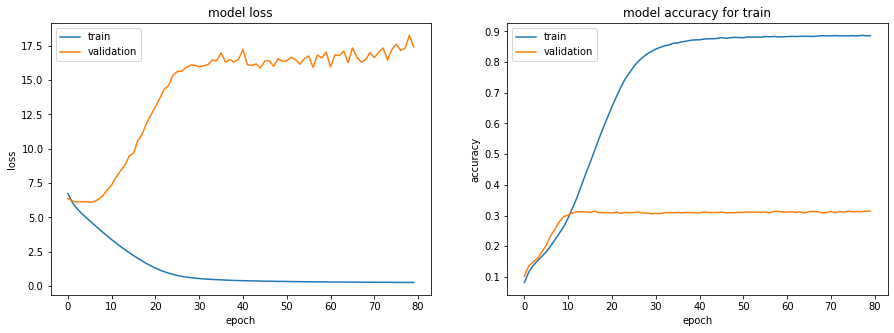

In [23]:
performace_nn(history0)

**Which conclusions we can make?**

- Is the NN well trained?
- Is it under or overfitting?
- Do the model generalize well?
- Which can be done to improve the NN?

In [ ]:
model1 = tf.keras.models.Sequential()
model1.add(tf.keras.layers.Embedding(vocabulary_size, seq_len, input_length=seq_len))
model1.add(tf.keras.layers.LSTM(50))
model1.add(tf.keras.layers.Dense(vocabulary_size, activation='softmax'))
print(model1.summary())

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 1e-4, patience = 5, verbose = 1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 3, min_lr=0.0001, verbose = 1)
mcp = tf.keras.callbacks.ModelCheckpoint(filepath = 'nextword1.h5', monitor = 'accuracy', save_best_only = True, verbose = 1, mode='auto')

In [ ]:
history1 = model1.fit(train, target, epochs=80, validation_split=0.2, verbose=1, callbacks=[es, rlr, mcp])

In [ ]:
performace_nn(history1)

In [ ]:
model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(vocabulary_size, seq_len, input_length=seq_len))
model2.add(tf.keras.layers.LSTM(units=50,return_sequences=True, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.LSTM(units=20, activation='relu'))
model2.add(tf.keras.layers.Dense(units=10, activation='relu'))
model2.add(tf.keras.layers.Dropout(0.2))
model2.add(tf.keras.layers.Dense(vocabulary_size, activation='softmax'))
print(model2.summary())

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Essential callbacks to follow the training model

es = tf.keras.callbacks.EarlyStopping(monitor = 'loss', min_delta = 1e-4, patience = 5, verbose = 1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.2, patience = 3, min_lr=0.0001, verbose = 1)
mcp = tf.keras.callbacks.ModelCheckpoint(filepath = 'nextword1.h5', monitor = 'accuracy', save_best_only = True, verbose = 1, mode='auto')

In [ ]:
history2 = model2.fit(train, target, epochs=80, validation_split=0.2, verbose=1, callbacks=[es, rlr, mcp])

In [ ]:
performace_nn(history2)

**Which did you observe?**

**What was the best model?**

**Is it really recommended use validation in this case?**

**Why performace in validation is lower compared to train?**


### 6) Testing the model

Using the model to predict some words.

Click here to read more about [widgets](https://ipywidgets.readthedocs.io/en/latest/examples/Using%20Interact.html)

In [24]:
model = tf.keras.models.load_model('nextword0.h5')
tokenizer = pickle.load(open('tokenizer.pkl', 'rb'))

In [25]:
from ipywidgets import widgets 

def predict_next_word(text):
  input_text = text.strip().lower()
  encoded_text = tokenizer.texts_to_sequences([input_text])[0]
  pad_encoded = tf.keras.preprocessing.sequence.pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')

  for i in (model.predict(pad_encoded)[0]).argsort()[-1:][::-1]:
    pred_word = tokenizer.index_word[i]

  return pred_word


widgets.interact(predict_next_word, text=input('press enter and typing your text...'));

press enter and typing your text...


interactive(children=(Text(value='', description='text'), Output()), _dom_classes=('widget-interact',))